# 5.2 - Using convnets with small datasets

- 基本的に，["Deep Learning with Python"](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438/)のSection 5.2(130-142ページ)を元にしている．  
- githubで入手可能な[原本のコード](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb)を解説を兼ねて多少改編している．  

## 5.2.1 The relavance of deep learning for small-data problems

この節では，データセットの少ない時の効果的な対策法を示す．  

- ドロップアウト(dropout): これは[前章](./Sect4.4-Fitting.ipynb)でも扱った内容である  
- **データ拡張(data augmentation)**  

## 5.2.2 Downloading the data

- 書籍では[Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data)を使っているが，今はダウンロードできなくなっている．  
- ここではその改良版である["Dogs vs. Cats Redux: Kernels Edition"](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)を用いる．  

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

- 上記のウェブサイトからファイルをダウンロードし，ダウンロードフォルダにそのまま解凍しておく．  

In [1]:
import os, shutil

## where we store dataset
base_dir = './data/cats_and_dogs_small'
os.makedirs(base_dir, exist_ok=True)

## directories for training in the directory above
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

## directories for validation in the directory above
validation_dir = os.path.join(base_dir, 'validation')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## directories for test in the directory above
test_dir = os.path.join(base_dir, 'test')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

上記データセットの訓練データを以下のように分けておく．  

- 最初の1000個の写真を訓練データ  
- 次の500個の写真を検証データ  
- その次の500個の写真をテストデータ  

In [2]:
## original data in the downloaded folder
original_dataset_dir = os.path.expanduser('~/Downloads/dogs-vs-cats-redux-kernels-edition/train')

# Copy first 1000 cat images to train_cats_dir
if not os.path.isdir(train_cats_dir):
    os.makedirs(train_cats_dir)
    fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(train_cats_dir, fname)
        shutil.copyfile(src, dst)

# Copy first 1000 dog images to train_dogs_dir
if not os.path.isdir(train_dogs_dir):
    os.makedirs(train_dogs_dir)
    fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(train_dogs_dir, fname)
        shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
if not os.path.isdir(validation_cats_dir):
    os.makedirs(validation_cats_dir)
    fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(validation_cats_dir, fname)
        shutil.copyfile(src, dst)

# Copy next 500 dog images to validation_dogs_dir
if not os.path.isdir(validation_dogs_dir):
    os.makedirs(validation_dogs_dir)
    fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(validation_dogs_dir, fname)
        shutil.copyfile(src, dst)

# Copy next 500 dog images to test_dogs_dir
if not os.path.isdir(test_dogs_dir):
    os.makedirs(test_dogs_dir)
    fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(test_dogs_dir, fname)
        shutil.copyfile(src, dst)

# Copy next 500 cat images to test_cats_dir
if not os.path.isdir(test_cats_dir):
    os.makedirs(test_cats_dir)
    fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(test_cats_dir, fname)
        shutil.copyfile(src, dst)

In [3]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## 5.2.3 Building our network

- 前節で調べた畳み込みネットワークの構造を適用してみる:
  + `relu`の活性化関数を用いた`Conv2D`
  + `MaxPooling2D`  
- MNISTに比べて複雑なデータを扱う: 150x150 (特に意味を持っている訳でなく，適当に決めた数)  
  + `Conv2D`+`MaxPooling2D`層を一つ追加する．  
  + その結果，平坦化直前では 7x7 の特徴マップが得られる．  
- 特徴は多くなるが(32$\rightarrow$128)，特徴マップは小さくなる(128x128$\rightarrow$7x7)点に注意．これは殆どの畳み込みネットワークで見られるパターンである．  
- 最適化手法としては，今までのように`RMSprop`を指定する．  
- 二値分類問題を解くため，最終の活性化関数として`sigmoid`を用いる．  

In [4]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Using TensorFlow backend.


## 5.2.4 Data preprocessing

- JPEG形式の画像ファイルを読み込むみ，RGBピクセル値を取り出す．  
- 画像のピクセル値(0-255)を浮動小数点型([0.0:1.0])のテンソルに変換する．  
  (ニューラルネットワークには小さい値が望ましい)

Kerasフレームワークはこれらの作業を自動的に行えるようなユーティリティでを内蔵している．  

- 画像の前処理用のパッケージ: `keras.preprocessing.image`  
- テンソル変換用の`ImageDataGenerator`クラスを用いる．  

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150), # all images will be resized to 150x150
        batch_size=20,
        class_mode='binary')    # since we use binary_crossentropy loss, we need binary labels

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators:
it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary labels (shape `(20,)`).
20 is the number of samples in each batch (the batch size).

In [6]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break ## train_generator yields data indefinitely: just break here

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


### 訓練

Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [7]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 31s 312ms/step - loss: 0.6910 - acc: 0.5425 - val_loss: 0.6788 - val_acc: 0.5750
Epoch 2/30
100/100 [==============================] - 24s 243ms/step - loss: 0.6601 - acc: 0.6100 - val_loss: 0.6712 - val_acc: 0.5750
Epoch 3/30
100/100 [==============================] - 24s 243ms/step - loss: 0.6119 - acc: 0.6665 - val_loss: 0.6337 - val_acc: 0.6350
Epoch 4/30
100/100 [==============================] - 24s 243ms/step - loss: 0.5592 - acc: 0.7075 - val_loss: 0.6140 - val_acc: 0.6550
Epoch 5/30
100/100 [==============================] - 25s 246ms/step - loss: 0.5396 - acc: 0.7235 - val_loss: 0.5946 - val_acc: 0.6730
Epoch 6/30
100/100 [==============================] - 24s 244ms/step - loss: 0.4981 - acc: 0.7665 - val_loss: 0.5678 - val_acc: 0.6910
Epoch 7/30
100/100 [==============================] - 24s 243ms/step - loss: 0.4671 - acc: 0.7805 - val_loss: 0.5660 - val_acc: 0.6910
Epoch 8/30
100/100 [==============================] - 2

In [8]:
## always save your model after training:
model.save('./data/cats_and_dogs_small_1.h5')

### 可視化

訓練時の訓練データと検証データに対する損失関数と精度を可視化する．

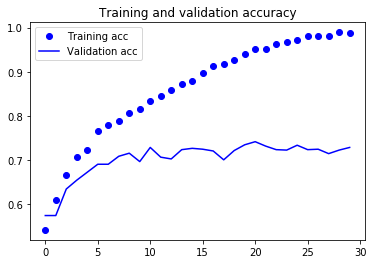

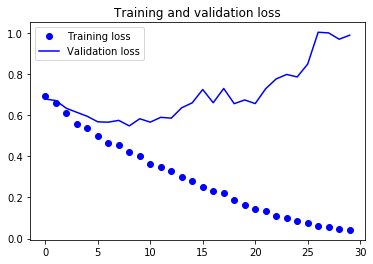

In [9]:
import matplotlib.pyplot as plt

def ShowProgress(acc, val_acc, loss, val_loss):
    epochs = range(len(acc))

    ## accuracy
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    ## validation
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    return None

## visualize
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

ShowProgress(acc, val_acc, loss, val_loss)

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to 
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data 
augmentation*.

## 5.2.5 Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. Let's get started with an example:

In [10]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

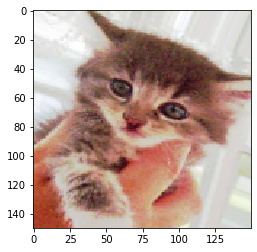

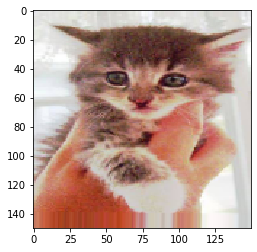

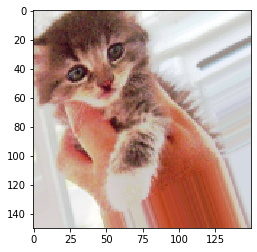

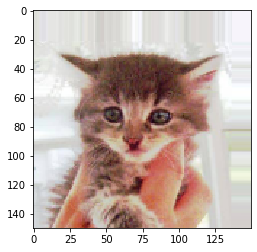

In [11]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) ## [ADDED] here we added drop-out layer
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 訓練

今度の訓練には，データ拡張とドロップアウトを使ってみよう:

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# [NOTE] validation data should not be augmented !
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 47s 468ms/step - loss: 0.6962 - acc: 0.5009 - val_loss: 0.6885 - val_acc: 0.4956
Epoch 2/30
100/100 [==============================] - 40s 397ms/step - loss: 0.6878 - acc: 0.5384 - val_loss: 0.6783 - val_acc: 0.5541
Epoch 3/30
100/100 [==============================] - 42s 419ms/step - loss: 0.6793 - acc: 0.5622 - val_loss: 0.6594 - val_acc: 0.5933
Epoch 4/30
100/100 [==============================] - 42s 420ms/step - loss: 0.6613 - acc: 0.5884 - val_loss: 0.6320 - val_acc: 0.6488
Epoch 5/30
100/100 [==============================] - 40s 398ms/step - loss: 0.6458 - acc: 0.6184 - val_loss: 0.6073 - val_acc: 0.6523
Epoch 6/30
100/100 [==============================] - 40s 402ms/step - loss: 0.6216 - acc: 0.6534 - val_loss: 0.5905 - val_acc: 0.6862
Epoch 7/30
100/100 [==============================] - 41s 411ms/step - loss: 0.6113 - acc: 0.6753 - val_lo

In [14]:
## save modified model (with dropout)
model.save('./data/cats_and_dogs_small_2.h5')

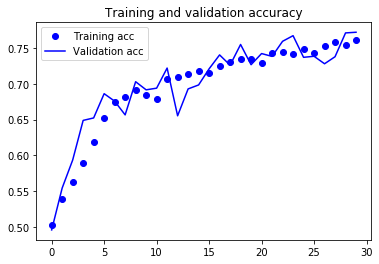

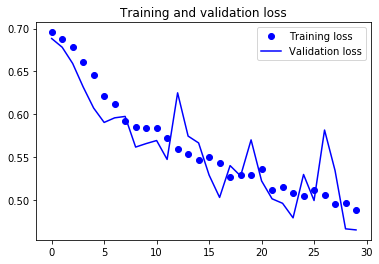

In [15]:
## visualize
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

ShowProgress(acc, val_acc, loss, val_loss)

100エポックに到達するまで，更に訓練させた上，可視化してみる:

In [16]:
## more training ...
history2 = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=70,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Epoch 1/70
 - 44s - loss: 0.4898 - acc: 0.7581 - val_loss: 0.5021 - val_acc: 0.7442
Epoch 2/70
 - 40s - loss: 0.4767 - acc: 0.7637 - val_loss: 0.4549 - val_acc: 0.7751
Epoch 3/70
 - 40s - loss: 0.4896 - acc: 0.7606 - val_loss: 0.4581 - val_acc: 0.7728
Epoch 4/70
 - 39s - loss: 0.4678 - acc: 0.7697 - val_loss: 0.4557 - val_acc: 0.7951
Epoch 5/70
 - 39s - loss: 0.4724 - acc: 0.7762 - val_loss: 0.4612 - val_acc: 0.7728
Epoch 6/70
 - 37s - loss: 0.4746 - acc: 0.7706 - val_loss: 0.4949 - val_acc: 0.7719
Epoch 7/70
 - 38s - loss: 0.4562 - acc: 0.7828 - val_loss: 0.4412 - val_acc: 0.7817
Epoch 8/70
 - 37s - loss: 0.4639 - acc: 0.7806 - val_loss: 0.4649 - val_acc: 0.7803
Epoch 9/70
 - 37s - loss: 0.4609 - acc: 0.7663 - val_loss: 0.4930 - val_acc: 0.7779
Epoch 10/70
 - 37s - loss: 0.4666 - acc: 0.7766 - val_loss: 0.4878 - val_acc: 0.7655
Epoch 11/70
 - 37s - loss: 0.4519 - acc: 0.7853 - val_loss: 0.4668 - val_acc: 0.7771
Epoch 12/70
 - 37s - loss: 0.4550 - acc: 0.7828 - val_loss: 0.4504 - val_a

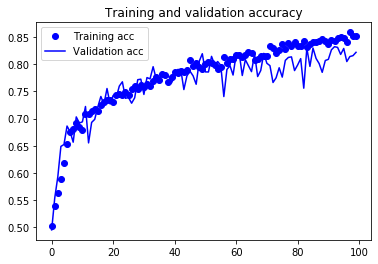

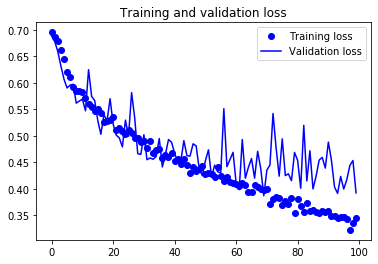

In [17]:
acc = history.history['acc'] + history2.history['acc']
val_acc = history.history['val_acc'] + history2.history['val_acc']
loss = history.history['loss'] + history2.history['loss']
val_loss = history.history['val_loss'] + history2.history['val_loss']

ShowProgress(acc, val_acc, loss, val_loss)

In [18]:
## overwrite model - this will be used in the Sect5.4.1
model.save('./data/cats_and_dogs_small_2.h5')

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation 
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution 
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove 
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a 
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two 
sections.

(end)